# Validation of the potentials

Once we have the fitted potentials, it is necessary to validate them in order to assess their quality with respect to applications.

In this exercise, we use the fitted potentials and perform some basic calculations.

## Import the fitted potentials for Li-Al (from earlier excercise)

The same directory contains a `helper.py` file which contains the necessary specifications of the ACE potential that we will validate now. For working with Pyiron, potentials are descrbed in the LAMMPS format as:
```
pot_ace = pd.DataFrame({
    'Name': ['LiAl_yace'],
    'Filename': [[os.path.abspath("../potentials/ACE/AlLi-6gen-18May.yace")]],
    'Model': ["ACE"],
    'Species': [['Al', 'Li']],
    'Config': [['pair_style pace\n', 'pair_coeff * * AlLi-6gen-18May.yace Al Li\n']]
})

```
A list of different interatomic potentials may be described in this manner. 

We import the list as:

In [1]:
from helper import pot_ace

pot = pot_ace.copy()
pot

,Name,Filename,Model,Species,Config
0,LiAl_yace,[/home/joyvan/forked_dpg2023/potentials/ACE/Al...,ACE,"[Al, Li]","[pair_style pace\n, pair_coeff * * AlLi-6gen-1..."


Handy function to quickly return the name of the potential for organization of results (very useful when working with multiple potentials)

In [2]:
from helper import get_clean_project_name

get_clean_project_name(pot)

'LiAl_yace'

## Import other important modules

In [3]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import time

from pyiron_atomistics import Project
from pyiron import pyiron_to_ase
import pyiron_gpl

# save start time to record runtime of the notebook
time_start =  time.time()
time_start

1679159445.8220205

## Create a new project to perform validation calculations

It is useful to create a new project directory for every kind of calculation. Here we specify the name of the main project directory and Pyiron will automatically create subdirectories for each potential and property we calculate. 

In [4]:
pr = Project("validation_LiAl")

# remove earlier jobs
pr.remove_jobs(silently=True, recursive=True)

  0%|          | 0/185 [00:00<?, ?it/s]

## Define the important pases to consider for validation

We construct a python dictionary `struct_dict` which contains a description of all the important phases that we want to consider for this exercise. The descriptions given in the dictionary will be later used by Pyiron to generate or read the structural configurations for the respective phases.

For unary phases, we provide an initial guess for the lattice parameter and use the `ase.build.bulk` functions implemented in pyiron to generate the structural prototype.

For binary phases, we provide a phase name and an additional dictionary `fl_dict` which maps the phase name to a `.cif` file saved in the subdirectory `mp_structures`. Pyiron will use this information to read the respective configurations from the file.

In [5]:
struct_dict = dict()

# structures to be generated automatically
struct_dict["Al"] = dict()
struct_dict["Al"]["s_murn"] = ["fcc","bcc"]
struct_dict["Al"]["a"] = 4.04

struct_dict["Li"] = dict()
struct_dict["Li"]["s_murn"] = ["bcc","fcc"]
struct_dict["Li"]["a"] = 3.5


# structures to be read from file
struct_dict["Li2Al2"] = dict()
struct_dict["Li2Al2"]["s_murn"] = ["Li2Al2_cubic"]

struct_dict["LiAl3"] = dict()
struct_dict["LiAl3"]["s_murn"] = ["LiAl3_tetragonal"]

struct_dict["LiAl3"] = dict()
struct_dict["LiAl3"]["s_murn"] = ["LiAl3_cubic"]

struct_dict["Li9Al4"] = dict()
struct_dict["Li9Al4"]["s_murn"] = ["Li9Al4_monoclinic"]

struct_dict["Li3Al2"] = dict()
struct_dict["Li3Al2"]["s_murn"] = ["Li3Al2_trigonal"]

struct_dict["Li4Al4"] = dict()
struct_dict["Li4Al4"]["s_murn"] = ["Li4Al4_cubic"]

struct_dict

{'Al': {'s_murn': ['fcc', 'bcc'], 'a': 4.04},
 'Li': {'s_murn': ['bcc', 'fcc'], 'a': 3.5},
 'Li2Al2': {'s_murn': ['Li2Al2_cubic']},
 'LiAl3': {'s_murn': ['LiAl3_cubic']},
 'Li9Al4': {'s_murn': ['Li9Al4_monoclinic']},
 'Li3Al2': {'s_murn': ['Li3Al2_trigonal']},
 'Li4Al4': {'s_murn': ['Li4Al4_cubic']}}

a dictionary is described to map the binary phases to their file locations

In [6]:
fl_dict = {"Li2Al2_cubic": "mp_structures/LiAl_mp-1067_primitive.cif",
           "LiAl3_tetragonal":"mp_structures/LiAl3_mp-975906_primitive.cif",
           "LiAl3_cubic":"mp_structures/LiAl3_mp-10890_primitive.cif",
           "Li9Al4_monoclinic":"mp_structures/Li9Al4_mp-568404_primitive.cif",
           "Li3Al2_trigonal":"mp_structures/Al2Li3-6021.cif",
           "Li4Al4_cubic":"mp_structures/LiAl_mp-1079240_primitive.cif"}

### Visualize the strucs

Once the structures are defined in the pyiron format, we can view their atomic coordinates and cell vectors using `struc.plot3d()`

In [7]:
# Option 1: use `ase.build.bulk` functionality in pyiron
struc = pr.create_ase_bulk("Al", "fcc", a=4.04,cubic=True)

# struc.plot3d()

/tmp/ipykernel_4635/356764707.py:2: DeprecationWarning: pyiron_atomistics.project.create_ase_bulk is deprecated: Use create.struture.bulk instead.
  struc = pr.create_ase_bulk("Al", "fcc", a=4.04,cubic=True)


In [8]:
# Option 2: Read from a file
struc = pr.create.structure.ase.read(fl_dict["Li4Al4_cubic"])

# struc.plot3d()

## (a) Ground state: E-V curves

Using a series of nested `for` loops, we calculate the murnaghan EV-curves using all three potentials for all the defined structures.

We loop over:
 - All the chemical formulae defined in the keys of `struct_dict`
   - All phases defined for a given chemical formula
     
Within the loops, the first step is to get the structure basis on which we will perform the calculations. 

- For unary phases, we use the pyiron function `pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])` 
- For binary structures, we read the basis using `pr.create.structure.ase.read(fl_path)` with the `fl_path` given by `fl_dict` defined earlier.

Once the structure and potential is defined as part of the pr_job, we run two calculations:
- `job_relax` to relax the structure to the ground state
- `murn_job` to calculate the energies in a small volume range around the equilibrium

As the calculations are being performed, the status(s) of each calculation is printed. If a job is already calculated, the calculations are not re-run but rather re-read from the saved data.

In [9]:
with pr.open(get_clean_project_name(pot)) as pr_pot:
    print(pr_pot)
    for compound, compound_dict in struct_dict.items():
        for crys_structure in compound_dict["s_murn"]:

            # Relax structure
            if crys_structure in ["fcc","bcc"]:
                basis = pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])
            else:
                basis = pr_pot.create.structure.ase.read(fl_dict[crys_structure])

            job_relax = pr_pot.create_job(pr_pot.job_type.Lammps, f"{compound}_{crys_structure}_relax", delete_existing_job=True)

            job_relax.structure = basis
            job_relax.potential = pot
            job_relax.calc_minimize(pressure=0)
            job_relax.run()

            # Murnaghan
            job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, f"ref_job_{compound}_{crys_structure}")
            job_ref.structure = job_relax.get_structure(-1)
            job_ref.potential = pot
            job_ref.calc_minimize()

            murn_job = job_ref.create_job(pr_pot.job_type.Murnaghan, f"murn_job_{compound}_{crys_structure}")
            murn_job.input["vol_range"] = 0.1
            murn_job.run()

/tmp/ipykernel_4635/2296293669.py:8: DeprecationWarning: pyiron_atomistics.project.create_ase_bulk is deprecated: Use create.struture.bulk instead.
  basis = pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])


/home/joyvan/forked_dpg2023/validation/validation_LiAl/LiAl_yace/
The job Al_fcc_relax was saved and received the ID: 1
The job murn_job_Al_fcc was saved and received the ID: 2
The job murn_job_Al_fcc_0_9 was saved and received the ID: 3
The job murn_job_Al_fcc_0_92 was saved and received the ID: 4
The job murn_job_Al_fcc_0_94 was saved and received the ID: 5
The job murn_job_Al_fcc_0_96 was saved and received the ID: 6
The job murn_job_Al_fcc_0_98 was saved and received the ID: 7
The job murn_job_Al_fcc_1_0 was saved and received the ID: 8
The job murn_job_Al_fcc_1_02 was saved and received the ID: 9
The job murn_job_Al_fcc_1_04 was saved and received the ID: 10
The job murn_job_Al_fcc_1_06 was saved and received the ID: 11
The job murn_job_Al_fcc_1_08 was saved and received the ID: 12
The job murn_job_Al_fcc_1_1 was saved and received the ID: 13


/tmp/ipykernel_4635/2296293669.py:8: DeprecationWarning: pyiron_atomistics.project.create_ase_bulk is deprecated: Use create.struture.bulk instead.
  basis = pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])


The job Al_bcc_relax was saved and received the ID: 14
The job murn_job_Al_bcc was saved and received the ID: 15
The job murn_job_Al_bcc_0_9 was saved and received the ID: 16
The job murn_job_Al_bcc_0_92 was saved and received the ID: 17
The job murn_job_Al_bcc_0_94 was saved and received the ID: 18
The job murn_job_Al_bcc_0_96 was saved and received the ID: 19
The job murn_job_Al_bcc_0_98 was saved and received the ID: 20
The job murn_job_Al_bcc_1_0 was saved and received the ID: 21
The job murn_job_Al_bcc_1_02 was saved and received the ID: 22
The job murn_job_Al_bcc_1_04 was saved and received the ID: 23
The job murn_job_Al_bcc_1_06 was saved and received the ID: 24
The job murn_job_Al_bcc_1_08 was saved and received the ID: 25
The job murn_job_Al_bcc_1_1 was saved and received the ID: 26


/tmp/ipykernel_4635/2296293669.py:8: DeprecationWarning: pyiron_atomistics.project.create_ase_bulk is deprecated: Use create.struture.bulk instead.
  basis = pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])


The job Li_bcc_relax was saved and received the ID: 27
The job murn_job_Li_bcc was saved and received the ID: 28
The job murn_job_Li_bcc_0_9 was saved and received the ID: 29
The job murn_job_Li_bcc_0_92 was saved and received the ID: 30
The job murn_job_Li_bcc_0_94 was saved and received the ID: 31
The job murn_job_Li_bcc_0_96 was saved and received the ID: 32
The job murn_job_Li_bcc_0_98 was saved and received the ID: 33
The job murn_job_Li_bcc_1_0 was saved and received the ID: 34
The job murn_job_Li_bcc_1_02 was saved and received the ID: 35
The job murn_job_Li_bcc_1_04 was saved and received the ID: 36
The job murn_job_Li_bcc_1_06 was saved and received the ID: 37
The job murn_job_Li_bcc_1_08 was saved and received the ID: 38
The job murn_job_Li_bcc_1_1 was saved and received the ID: 39


/tmp/ipykernel_4635/2296293669.py:8: DeprecationWarning: pyiron_atomistics.project.create_ase_bulk is deprecated: Use create.struture.bulk instead.
  basis = pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])


The job Li_fcc_relax was saved and received the ID: 40
The job murn_job_Li_fcc was saved and received the ID: 41
The job murn_job_Li_fcc_0_9 was saved and received the ID: 42
The job murn_job_Li_fcc_0_92 was saved and received the ID: 43
The job murn_job_Li_fcc_0_94 was saved and received the ID: 44
The job murn_job_Li_fcc_0_96 was saved and received the ID: 45
The job murn_job_Li_fcc_0_98 was saved and received the ID: 46
The job murn_job_Li_fcc_1_0 was saved and received the ID: 47
The job murn_job_Li_fcc_1_02 was saved and received the ID: 48
The job murn_job_Li_fcc_1_04 was saved and received the ID: 49
The job murn_job_Li_fcc_1_06 was saved and received the ID: 50
The job murn_job_Li_fcc_1_08 was saved and received the ID: 51
The job murn_job_Li_fcc_1_1 was saved and received the ID: 52
The job Li2Al2_Li2Al2_cubic_relax was saved and received the ID: 53
The job murn_job_Li2Al2_Li2Al2_cubic was saved and received the ID: 54
The job murn_job_Li2Al2_Li2Al2_cubic_0_9 was saved and rec

One can display the technical details of all submitted jobs using `pr.job_table()` below.

In [10]:
# pr.job_table()

In order to get read useful results from the completed calculations (eq_energy, eq_volume, etc), it is useful to define the following functions

In [11]:
# Only work with Murnaghan jobs
def get_only_murn(job_table):
    return (job_table.hamilton == "Murnaghan") & (job_table.status == "finished") 

def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path.project.path.split("/")[-3]

def get_eq_energy(job_path):
    return job_path["output/equilibrium_energy"]

def get_n_atoms(job_path):
    return len(job_path["output/structure/positions"])

def get_ase_atoms(job_path):
    return pyiron_to_ase(job_path.structure).copy()


def get_potential(job_path):
    return job_path.project.path.split("/")[-2]

def get_crystal_structure(job_path):
    return job_path.job_name.split("_")[-1]

def get_compound(job_path):
    return job_path.job_name.split("_")[-2]

Using the functions defined above, one can now define a `pd.DataFrame` containing all useful results

In [12]:
# Compile data using pyiron tables
table = pr.create_table("table_murn", delete_existing_job=True)
table.convert_to_object = True
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["ase_atoms"] = get_ase_atoms
table.add["compound"] = get_compound
table.add["crystal_structure"] = get_crystal_structure
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm
table.add["eq_energy"] = get_eq_energy
table.add["n_atoms"] = get_n_atoms
table.run()

data_murn = table.get_dataframe()
data_murn["phase"] = data_murn.compound + "_" + data_murn.crystal_structure
data_murn

The job table_murn was saved and received the ID: 118


Loading and filtering jobs:   0%|          | 0/9 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/9 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyiron_base/jobs/datamining.py:620: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['potential', 'ase_atoms', 'compound', 'crystal_structure'], dtype='object')]

  self.pyiron_table._df.to_hdf(


,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,2,LiAl_yace,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.044553,16.541593,87.130343,-3.478909,1,Al_fcc
1,15,LiAl_yace,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.953036,16.811333,72.667314,-3.388831,1,Al_bcc
2,28,LiAl_yace,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.216389,20.403221,15.823766,-1.756104,1,Li_bcc
3,41,LiAl_yace,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,fcc,4.331457,20.318996,14.231553,-1.755594,1,Li_fcc
4,54,LiAl_yace,"(Atom('Li', [4.50219440460198, 2.5993430614471436, 1.8380131721496582], index=0), Atom('Li', [6.753291606903076, 3.8990147113800044, 2.7570197582244873], index=1), Atom('Al', [-4.9636607055274905e...",Li2Al2,cubic,6.367064,64.521780,46.107330,-11.185880,4,Li2Al2_cubic
5,67,LiAl_yace,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [2.0106544494628906, 2.0106544494628906, 2.4623414536294e-16], index=1), Atom('Al', [2.0106544494628906, 1.2311707268147e-16, 2.0106544494628906],...",LiAl3,cubic,5.686990,65.028378,66.254764,-12.569153,4,LiAl3_cubic
6,80,LiAl_yace,"(Atom('Li', [5.141009330749512, 1.0571138858795168, 0.8202494382858275], index=0), Atom('Li', [3.270578861236572, 1.5045549869537354, 2.7151594161987305], index=1), Atom('Li', [-3.601125717163085,...",Li9Al4,monoclinic,13.519944,213.136108,33.963046,-31.796315,13,Li9Al4_monoclinic
7,93,LiAl_yace,"(Atom('Al', [2.227097749710083, 1.2858164310455322, 1.902564644813538], index=0), Atom('Al', [-2.2270956039428715, 3.857446193695068, 2.7757666110992436], index=1), Atom('Li', [8.407589575653831e-...",Li3Al2,trigonal,6.299181,80.375088,39.642906,-13.138303,5,Li3Al2_trigonal
8,106,LiAl_yace,"(Atom('Li', [2.226986885070801, 1.2857515811920164, 7.8640265464782715], index=0), Atom('Li', [-1.5554061290578905e-09, 2.571503162384033, 0.7130584716796876], index=1), Atom('Li', [-1.55540612905...",Li4Al4,cubic,6.298870,147.356917,46.701247,-21.607232,8,Li4Al4_cubic


DFT reference data, when possible has been saved in `.pckl` files in the directory. We plot the DFT results along with the predictions from the ACE potential in the same plot

In [13]:
# read dft murnaghan data
df_dft_ref = pd.read_pickle("dft_murn_ref.pckl")

al_fcc = df_dft_ref[df_dft_ref["compound"]=="Al_fcc"]
li = df_dft_ref[df_dft_ref["compound"].isin(["Li_bcc","Li_fcc"])]
df_mixed = df_dft_ref[df_dft_ref["compound"].isin(["LiAl_mp-1067","LiAl3_mp-10890","Li9Al4_mp-568404","Li3Al2_mp-16506","LiAl_mp-1079240"])]

li["energy_per_atom"] = li["energy"]/li["number_of_atoms"]
# li

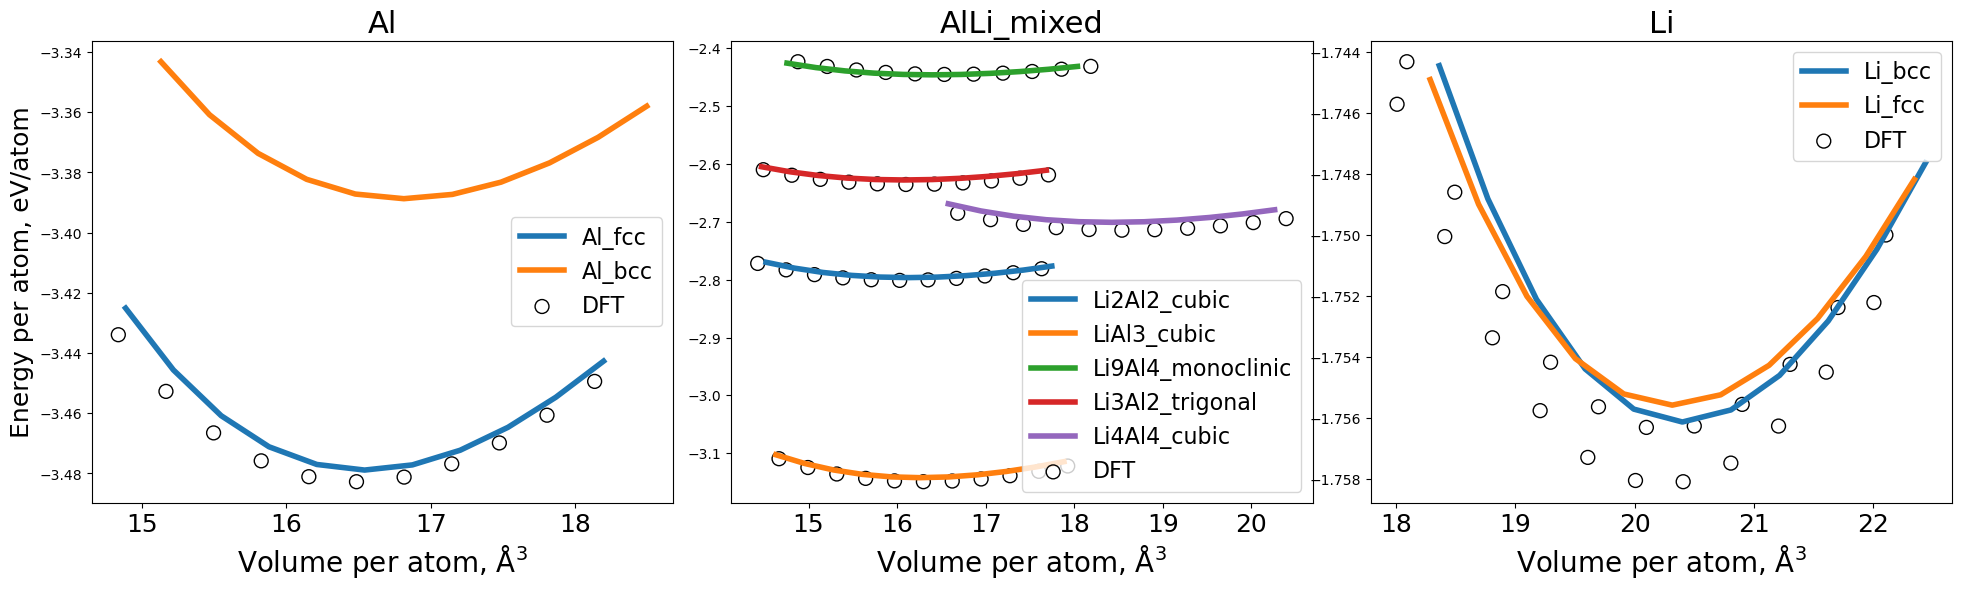

In [14]:
fig, ax_list = plt.subplots(ncols=3, nrows=1, sharex="col")

fig.set_figwidth(24)
fig.set_figheight(6)

color_palette = sns.color_palette("tab10", n_colors=len(data_murn.phase.unique()))


# for i, pot in enumerate(potentials_list):
    

mask1 = data_murn["compound"]=="Al"
data1 = data_murn[(data_murn.potential == get_clean_project_name(pot)) & (mask1)]

mask2 = data_murn["compound"]=="Li"
data2 = data_murn[(data_murn.potential == get_clean_project_name(pot)) & (mask2)]

mask3 = data_murn["compound"].isin(["Al","Li"])
data3 = data_murn[(data_murn.potential == get_clean_project_name(pot)) & (~mask3)]

for j,(_, row) in enumerate(data1.iterrows()):
    murn_job = pr.load(row["job_id"])
    murn_df = murn_job.output_to_pandas()
    n_atoms = row["n_atoms"]

    ax_list[0].plot(murn_df["volume"]/n_atoms, murn_df["energy"]/n_atoms,"-",
                        lw=4,
                        label= row["phase"], 
                        color=color_palette[j])



    ax_list[0].set_title(data1.iloc[0]["compound"],fontsize=22)
    ax_list[0].legend(prop={"size":16})

ax_list[0].scatter(al_fcc["vol"],al_fcc["energy"]/al_fcc["number_of_atoms"],
                        facecolor="none",edgecolor="k",s=100,label="DFT")

for j,(_, row) in enumerate(data2.iterrows()):
    murn_job = pr.load(row["job_id"])
    murn_df = murn_job.output_to_pandas()
    n_atoms = row["n_atoms"]

    ax_list[2].plot(murn_df["volume"]/n_atoms, murn_df["energy"]/n_atoms,"-",
                        lw=4,
                        label= row["phase"], 
                        color=color_palette[j])



    ax_list[2].set_title(data2.iloc[0]["compound"],fontsize=22)
    # ax_list[2].legend(prop={"size":16})

ax_list[2].scatter(li["vol"],li["energy"]/li["number_of_atoms"],
                        facecolor="none",edgecolor="k",s=100,label="DFT")

for j,(_, row) in enumerate(data3.iterrows()):
    murn_job = pr.load(row["job_id"])
    murn_df = murn_job.output_to_pandas()
    n_atoms = row["n_atoms"]

    ax_list[1].plot(murn_df["volume"]/n_atoms, murn_df["energy"]/n_atoms,"-",
                        lw=4,
                        label= row["phase"], 
                        color=color_palette[j])

    ax_list[1].set_title('AlLi_mixed',fontsize=22)
    # ax_list[1].legend(prop={"size":16})

ax_list[1].scatter(df_mixed["vol"],df_mixed["energy"]/df_mixed["number_of_atoms"],
                        facecolor="none",edgecolor="k",s=100,label="DFT")
        
        
for i in range(3):
    ax_list[i].legend(prop={"size":16})
    ax_list[i].set_xlabel("Volume per atom, $\mathrm{\AA^3}$",fontsize=20)
    ax_list[i].tick_params(axis="x",labelsize=18)
    
ax_list[0].set_ylabel("Energy per atom, eV/atom",fontsize=18)
    
    
    
# ax.legend(prop={"size":16})
# ax.set_ylabel("Energy per atom, eV/atom",fontsize=20)
#break
fig.subplots_adjust(wspace=0.1);

## (b) Elastic constants and Phonons

Pyiron also has job modules to calculate elastic constants and thermal properties using the quasi-harmonic approximation given by the `phonopy` package.

As in the previous task, we again loop over the given structures.

Calculating elastic constants and thermal properties is considerably more expensive than calculating EV curves. Hence, it is useful to only calculate these properties for a subset of most important structures 

In [15]:
list_of_phases = ["Al_fcc","Li_bcc","Li2Al2_cubic","LiAl3_cubic"]

subset_murn = data_murn[data_murn["phase"].isin(list_of_phases)]
subset_murn

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,2,LiAl_yace,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.044553,16.541593,87.130343,-3.478909,1,Al_fcc
2,28,LiAl_yace,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.216389,20.403221,15.823766,-1.756104,1,Li_bcc
4,54,LiAl_yace,"(Atom('Li', [4.50219440460198, 2.5993430614471436, 1.8380131721496582], index=0), Atom('Li', [6.753291606903076, 3.8990147113800044, 2.7570197582244873], index=1), Atom('Al', [-4.9636607055274905e...",Li2Al2,cubic,6.367064,64.521780,46.107330,-11.185880,4,Li2Al2_cubic
5,67,LiAl_yace,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [2.0106544494628906, 2.0106544494628906, 2.4623414536294e-16], index=1), Atom('Al', [2.0106544494628906, 1.2311707268147e-16, 2.0106544494628906],...",LiAl3,cubic,5.686990,65.028378,66.254764,-12.569153,4,LiAl3_cubic


In [16]:


group_name = get_clean_project_name(pot)
pr_pot = pr.create_group(group_name)
print(group_name)

for _, row in subset_murn[subset_murn.potential==group_name].iterrows():
    job_id = row["job_id"]

    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, f"ref_job_{row.compound}_{row.crystal_structure}")
    ref = pr_pot.load(job_id)
    job_ref.structure = ref.structure
    job_ref.potential = pot
    job_ref.calc_minimize()

    elastic_job = job_ref.create_job(pr_pot.job_type.ElasticMatrixJob, f"elastic_job_{row.compound}_{row.crystal_structure}")
    elastic_job.input["eps_range"] = 0.05
    elastic_job.run()


    phonopy_job = job_ref.create_job(pr_pot.job_type.PhonopyJob, f"phonopy_job_{row.compound}_{row.crystal_structure}")
    job_ref.calc_static()
    phonopy_job.run()

LiAl_yace
The job elastic_job_Al_fcc was saved and received the ID: 119
The job s_e_0 was saved and received the ID: 120
The job s_01_e_m0_05000 was saved and received the ID: 121
The job s_01_e_m0_02500 was saved and received the ID: 122
The job s_01_e_0_02500 was saved and received the ID: 123
The job s_01_e_0_05000 was saved and received the ID: 124
The job s_08_e_m0_05000 was saved and received the ID: 125
The job s_08_e_m0_02500 was saved and received the ID: 126
The job s_08_e_0_02500 was saved and received the ID: 127
The job s_08_e_0_05000 was saved and received the ID: 128
The job s_23_e_m0_05000 was saved and received the ID: 129
The job s_23_e_m0_02500 was saved and received the ID: 130
The job s_23_e_0_02500 was saved and received the ID: 131
The job s_23_e_0_05000 was saved and received the ID: 132
The job phonopy_job_Al_fcc was saved and received the ID: 133
The job ref_job_Al_fcc_0 was saved and received the ID: 134
The job elastic_job_Li_bcc was saved and received the I

In [17]:
def filter_elastic(job_table):
    return (job_table.hamilton == "ElasticMatrixJob") & (job_table.status == "finished")

# Get corresponding elastic constants
def get_c11(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 0]

def get_c12(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 1]

def get_c44(job_path):
    return job_path["output/elasticmatrix"]["C"][3, 3]

In [18]:
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = filter_elastic
table.add["potential"] = get_potential
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44
table.add["compound"] = get_compound
table.add["crystal_structure"] = get_crystal_structure

table.run()
data_elastic = table.get_dataframe()
data_elastic["phase"] = data_elastic.compound + "_" + data_elastic.crystal_structure
data_elastic = data_elastic[data_elastic["phase"].isin(list_of_phases)]
data_elastic

The job table_elastic was saved and received the ID: 185


Loading and filtering jobs:   0%|          | 0/4 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/4 [00:00<?, ?it/s]

,job_id,potential,C11,C12,C44,compound,crystal_structure,phase
0,119,LiAl_yace,133.806835,62.693977,40.423190,Al,fcc,Al_fcc
1,135,LiAl_yace,18.307939,13.775446,12.106597,Li,bcc,Li_bcc
2,151,LiAl_yace,114.274859,13.925798,42.537946,Li2Al2,cubic,Li2Al2_cubic
3,168,LiAl_yace,112.037436,42.770836,45.206489,LiAl3,cubic,LiAl3_cubic


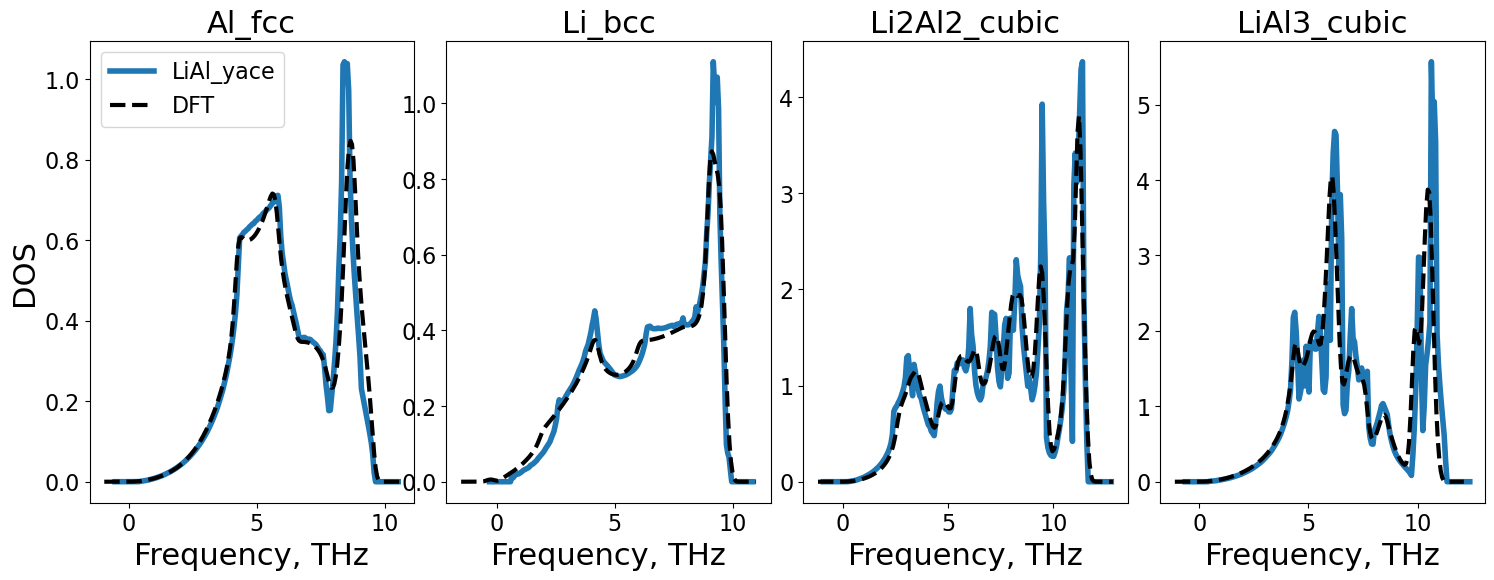

In [19]:
fig, ax_list = plt.subplots(ncols=len(data_elastic.phase.unique()), nrows=1,)

fig.set_figwidth(18)
fig.set_figheight(6)

color_palette = sns.color_palette("tab10", n_colors=len(data_elastic.potential.unique()))

for i, phase in enumerate(data_elastic.phase.unique()):
    
    ax = ax_list[i]
    # data = data_elastic[(data_elastic.phase == phase) & (data_elastic["potential"]=="pot")]
    data = data_elastic[(data_elastic.phase == phase)]
    
    # DFT data is read from csv files
    dft_ref = pd.read_csv(phase.lower()+"_dos.csv")
    
    
    phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]

    thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)



    ax.plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
            lw=4,
            color=color_palette[0], 
            label=get_clean_project_name(pot))



    ax.set_xlabel("Frequency, THz",fontsize=22)
        
    ax.plot(dft_ref["dos_energy"],dft_ref["dos_total"],ls="--",lw=3,color="k",label="DFT")
        
    ax.set_title(f"{phase}",fontsize=22)
    ax.tick_params(labelsize=16)
ax_list[0].set_ylabel("DOS",fontsize=22)

ax_list[0].legend(prop={"size":16})
fig.subplots_adjust(wspace=0.1);

Using `phonopy` we may also plot the full band structure (DFT ref is unavailable for this property)

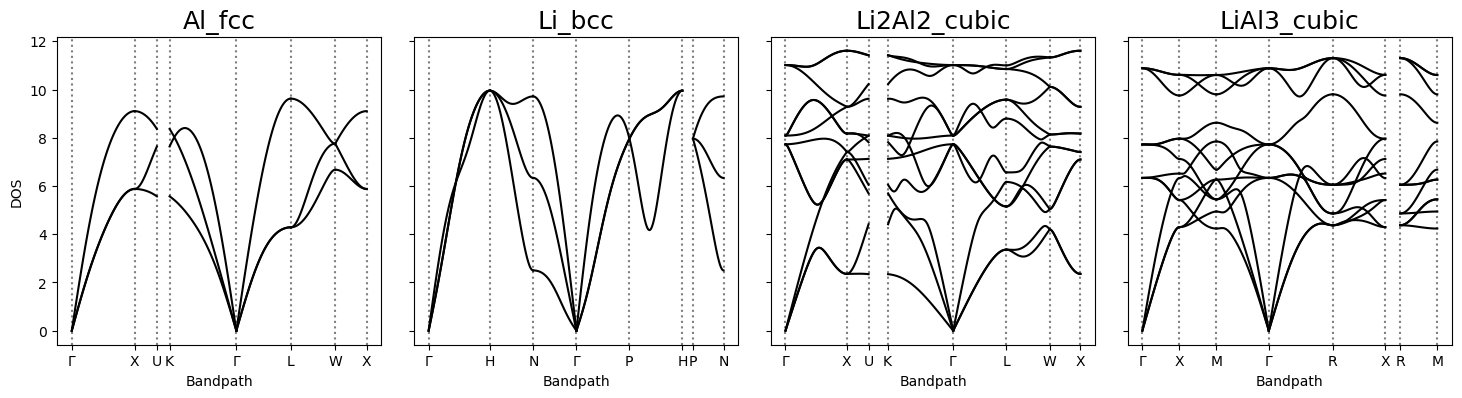

In [20]:
fig, ax_list = plt.subplots(ncols=len(data_elastic.phase.unique()), nrows=1, sharey="row")

fig.set_figwidth(18)
fig.set_figheight(4)

color_palette = sns.color_palette("tab10", n_colors=len(data_elastic.potential.unique()))


for i, phase in enumerate(data_elastic.phase.unique()):
    
    
    data = data_elastic[data_elastic.phase == phase]
    
    # for j, pot in enumerate(potentials_list):
    ax = ax_list[i]
    phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]

    phonopy_job.plot_band_structure(axis=ax)
    ax.set_ylabel("")
    ax.set_title(phase,fontsize=18)
    ax_list[0].set_ylabel("DOS")
    # ax_list[0].set_title(f"{phase}")
fig.subplots_adjust(wspace=0.1, hspace=0.4);

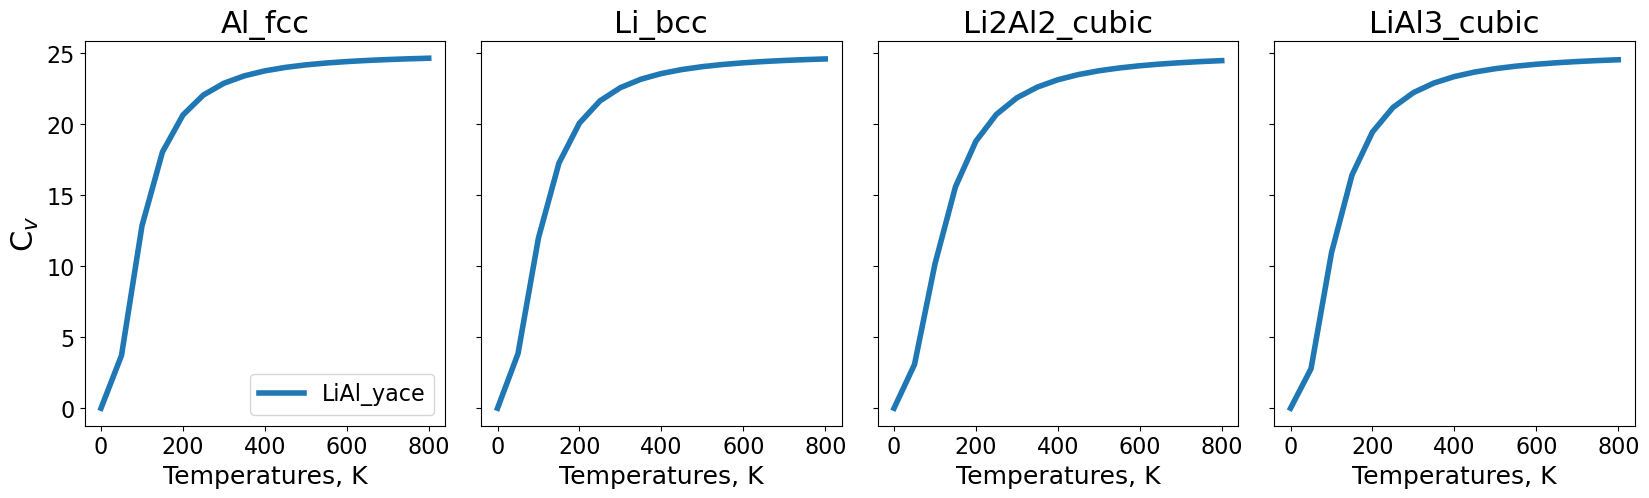

In [21]:
fig, ax_list = plt.subplots(ncols=len(data_elastic.phase.unique()), nrows=1, sharex="row", sharey="row")

fig.set_figwidth(20)
fig.set_figheight(5)

color_palette = sns.color_palette("tab10", n_colors=len(data_elastic.potential.unique()))


for i, phase in enumerate(data_elastic.phase.unique()):
    
    ax = ax_list[i]
    data = data_elastic[data_elastic.phase == phase]
    
    n_atom = data_murn[data_murn["phase"]==phase]["n_atoms"].iloc[0]
    
    
    phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]

    thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)

    ax.plot(thermo.temperatures, thermo.cv/n_atom,
            lw=4,
            label=get_clean_project_name(pot), 
            color=color_palette[0])
    ax.set_xlabel("Temperatures, K",fontsize=18)
    ax.set_title(f"{phase}",fontsize=22)
    ax.tick_params(labelsize=16)
ax_list[0].set_ylabel("C$_v$",fontsize=22)

ax_list[0].legend(prop={"size":16})
fig.subplots_adjust(wspace=0.1);

## (c) Convex hull

To assess the stability of the binary phases, we plot a convex hull for the considered phases. 

For this task we compute the formation energies of the mixed phases relative to ground state energies of equilibrium unary phases.

In [22]:
from collections import Counter

data_convexhull = data_murn.copy()
data_convexhull.head(3)

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,2,LiAl_yace,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.044553,16.541593,87.130343,-3.478909,1,Al_fcc
1,15,LiAl_yace,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.953036,16.811333,72.667314,-3.388831,1,Al_bcc
2,28,LiAl_yace,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.216389,20.403221,15.823766,-1.756104,1,Li_bcc


Using `Collections.counter` we construct a composition dictionary for all the phases and from that dictionary, we can extract the relative concentrations of Al and Li in each structure

Obtain the equilibrium energies for unary Al and Li phases from the Dataframe

Calculate the relative formation energies by subtracting the total energies of the mixed phases with the energies of eq Al and Li

$$E^{A_xB_y}_{f} = E_{A_xB_y} - (x E_A + yE_B)$$

Similarly calculate the formation energies from DFT ref data

In [23]:
def get_e_form(data_convexhull):
    data_convexhull["comp_dict"] = data_convexhull["ase_atoms"].map(lambda at: Counter(at.get_chemical_symbols()))
    data_convexhull["n_Al"] = data_convexhull["comp_dict"].map(lambda d: d.get("Al",0))
    data_convexhull["n_Li"] = data_convexhull["comp_dict"].map(lambda d: d.get("Li",0))

    data_convexhull["cAl"]= data_convexhull["n_Al"]/data_convexhull["n_atoms"] * 100
    data_convexhull["cLi"]= data_convexhull["n_Li"]/data_convexhull["n_atoms"] * 100

    E_f_Al = data_convexhull.loc[data_convexhull["n_Li"]==0,"eq_energy"].min()
    E_f_Li = data_convexhull.loc[data_convexhull["n_Al"]==0,"eq_energy"].min()

    data_convexhull["E_form"]=(data_convexhull["eq_energy"])-(data_convexhull[["n_Al","n_Li"]].values * [E_f_Al, E_f_Li]).sum(axis=1)
    data_convexhull["E_form_per_atom"] = data_convexhull["E_form"]/data_convexhull["n_atoms"] * 1e3

    data_convexhull = data_convexhull.sort_values("cLi")

    return data_convexhull

data_convexhull = get_e_form(data_convexhull)

Read df which contains DFT ref data for plotting

In [24]:
convex_ref = pd.read_pickle("dft_convexhull_ref.pckl")
convex_ref

,name,energy,vol,compound,ao,number_of_atoms,comp_dict,n_Al,n_Li,cAl,cLi,E_form,E_form_per_atom
438,/home/users/lysogy36/tools/VASP/Al-Li/DFT/Al_fcc/murn/strain_1_0/data.json,-13.930995,16.484415,Al_fcc,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('Al', [0.0, 2.019983601551115, 2.019983601551115], index=1), Atom('Al', [2.019983601551115, 0.0, 2.019983601551115], index=2), Atom('Al', [2.01998360155...",4,{'Al': 4},4,0,100.000000,0.000000,0.000000,0.000000
910,/home/users/lysogy36/tools/VASP/Al-Li/DFT/LiAl3_mp-10890/murn/strain_1_0/data.json,-12.597018,16.295840,LiAl3_mp-10890,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [2.0122514573524146, 2.0122514573524146, 0.0], index=1), Atom('Al', [2.0122514573524146, 0.0, 2.0122514573524146], index=2), Atom('Al', [0.0, 2.01...",4,"{'Li': 1, 'Al': 3}",3,1,75.000000,25.000000,-0.392474,-98.118408
1950,/home/users/lysogy36/tools/VASP/Al-Li/DFT/LiAl_mp-1067/murn/strain_1_0/data.json,-11.204795,16.028228,LiAl_mp-1067,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Li', [2.246243529971499, 1.2968693066945, 0.9170250810763773], index=1), Atom('Al', [4.492487059942998, 2.593738613389, 1.8340501621527545], index=2), ...",4,"{'Li': 2, 'Al': 2}",2,2,50.000000,50.000000,-0.726701,-181.675339
1275,/home/users/lysogy36/tools/VASP/Al-Li/DFT/LiAl_mp-1079240/murn/strain_1_0/data.json,-21.715330,18.537039,LiAl_mp-1079240,"(Atom('Li', [-2.093764484173552e-06, 2.574581270471953, 3.588630766943668], index=0), Atom('Li', [2.229653899294873, 1.2872887040708958, 5.022609593138096], index=1), Atom('Li', [2.229653899294873...",8,"{'Li': 4, 'Al': 4}",4,4,50.000000,50.000000,-0.759143,-94.892853
652,/home/users/lysogy36/tools/VASP/Al-Li/DFT/Li3Al2_mp-16506/murn/strain_1_0/data.json,-13.176984,16.098544,Li3Al2_mp-16506,"(Atom('Li', [7.387307289355338, 3.3557842846492325, 2.205190367378745], index=0), Atom('Li', [4.984874333407062, 2.2644466100798333, 1.488038392346624], index=1), Atom('Li', [0.0, 0.0, 0.0], index...",5,"{'Li': 3, 'Al': 2}",2,3,40.000000,60.000000,-0.942593,-188.518538
231,/home/users/lysogy36/tools/VASP/Al-Li/DFT/Li9Al4_mp-568404/murn/strain_1_0/data.json,-31.786765,16.532577,Li9Al4_mp-568404,"(Atom('Li', [15.085585487572331, 3.6087478779487228, 4.372653838370371], index=0), Atom('Li', [13.209884188064274, 3.160045831227256, 2.4668794892606694], index=1), Atom('Li', [6.31626414433567, 1...",13,"{'Li': 9, 'Al': 4}",4,9,30.769231,69.230769,-2.049089,-157.622253
1343,/home/users/lysogy36/tools/VASP/Al-Li/DFT/Li_bcc/murn/strain_1_0/data.json,-3.512596,20.099126,Li_bcc,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Li', [1.712796338409787, 1.712796338409787, 1.712796338409787], index=1))",2,{'Li': 2},0,2,0.000000,100.000000,0.000000,0.000000


Define a function to automatically get the mathematical convex hull

In [25]:
from scipy.spatial import ConvexHull,convex_hull_plot_2d

def get_convexhull(df):
    df_tmp = df.copy().reset_index()

    points = np.zeros([len(df_tmp["cLi"]),2])

    for i,row in df_tmp.iterrows():
        points[i,0], points[i,1] =  float(row["cLi"]), float(row["E_form_per_atom"])
        
    hull = ConvexHull(points)
    return hull,points

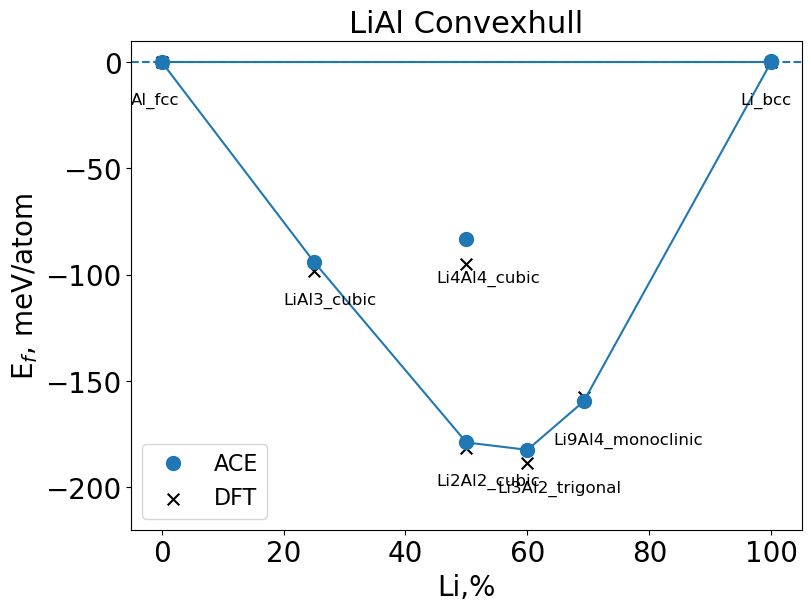

In [26]:
fig,ax = plt.subplots(figsize=(8,6),ncols=1,constrained_layout=True,sharey="row")

df_tmp = data_convexhull.copy()

# ax.scatter(data_convexhull["cLi"],data_convexhull["E_form_per_atom"],marker="o",s=50)


df_tmp = data_convexhull[(data_convexhull["E_form_per_atom"]<0.1) & (data_convexhull["E_form"]<0.1)]
hull,points = get_convexhull(df_tmp)

for simplex in hull.simplices:
    ax.plot(points[simplex, 0], points[simplex, 1], color=color_palette[0])


ax.axhline(0,ls="--",color=color_palette[0])

ax.plot(data_convexhull["cLi"], data_convexhull["E_form_per_atom"],"o",
        markersize=10,
        color=color_palette[0],
        label="ACE")

ax.scatter(convex_ref["cLi"],convex_ref["E_form_per_atom"],
           marker="x",
           color="k",
           s=70,
           label="DFT")

ax.legend(prop={"size":16})
ax.set_xlabel("Li,%",fontsize="20")
ax.set_ylabel("E$_f$, meV/atom",fontsize="20")
ax.tick_params(labelsize=20,axis="both")
ax.set_ylim(-220,10)

for _,row in df_tmp.iterrows():
    ax.text((row["cLi"]-5),row["E_form_per_atom"]-20,row["phase"],size=12)

ax.set_title("LiAl Convexhull",fontsize=22)

plt.show()

In [27]:
time_stop = time.time()
print(f"Total run time for the notebook {time_stop - time_start} seconds")

Total run time for the notebook 276.9380621910095 seconds
